In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, recall_score

import mlrose_hiive
from time import time

In [2]:
train = pd.read_csv('data/diabetes_data.csv')
test = pd.read_csv('data/test_diabetes_data.csv')

In [3]:
train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income,IsMale,Diabetes
0,False,False,False,66.0,False,False,False,False,True,True,False,True,False,5.0,0.0,30.0,True,9.0,4.0,5.0,False,True
1,False,False,False,34.0,False,False,False,True,False,True,False,True,False,3.0,0.0,0.0,False,7.0,6.0,8.0,False,True
2,False,False,False,30.0,False,False,False,True,True,True,False,True,False,3.0,0.0,2.0,False,6.0,6.0,8.0,True,True
3,False,False,False,39.0,False,False,False,True,True,True,False,True,False,2.0,2.0,10.0,True,4.0,5.0,5.0,False,True
4,False,False,False,37.0,True,False,False,False,False,True,False,True,False,2.0,0.0,0.0,False,7.0,6.0,7.0,True,True


In [4]:
for col in train.columns:
    train[col] = train[col].astype(np.float)
    test[col] = test[col].astype(np.float)

In [5]:
X_train = train.drop('Diabetes', axis=1)
y_train = train['Diabetes']
X_test  = test.drop('Diabetes', axis=1)
y_test = test['Diabetes']

## Search Algorithms 

In [42]:
## fix 
learning_rates = [0.01, 0.1, 1]
restarts       = [6, 8, 10]
schedules      = [mlrose_hiive.GeomDecay(), mlrose_hiive.ExpDecay(), mlrose_hiive.ArithDecay()]
scheduleNames  = ['GeomDecay', 'ExpDecay', 'ArithDecay']
populations    = [20, 50, 100]

In [22]:
def get_recall(model, X_test, y_test):
    y_pred = model.predict(X_test)
    recall = classification_report(y_test, y_pred, output_dict=True)['1.0']['recall']
    return recall

## Random Hill Climb

In [58]:
rh_scores     = []
best_rh_fitness = 0
best_rh_score = 0
best_fitness_score = 0
best_rh_model = None
for lr in learning_rates:
    for restart in restarts:
        rh = mlrose_hiive.NeuralNetwork(
            hidden_nodes      = [25], 
            activation        = 'relu',
            algorithm         = 'random_hill_climb',
            restarts          = restart, 
            is_classifier     = True,
            learning_rate     = lr,
            max_attempts      = 50,
            random_state      = 0,
            early_stopping    = True,
            max_iters         = 100,
            curve             = True
        )
        start = time()
        rh.fit(X_train, y_train)
        rh_time = time() - start
        score = get_recall(rh, X_test, y_test)
        rh_scores.append({'LearningRate':lr, 'Restart':restart, 'Score':score, 'Time':rh_time, 'Loss':rh.loss, 'Fitness':rh.fitness_curve[-1,0]})
        if rh.fitness_curve[-1,0] > best_rh_fitness:
            best_rh_fitness = rh.fitness_curve[-1,0]
            best_rh_model = rh
        print(f'best score: {best_rh_score} \
        Current Score: {score} \
        Learning Rate: {lr} \
        Restart: {restart}\
        Fitness: {rh.fitness_curve[-1,0]}', 
              end='\r')

In [28]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Fitness')

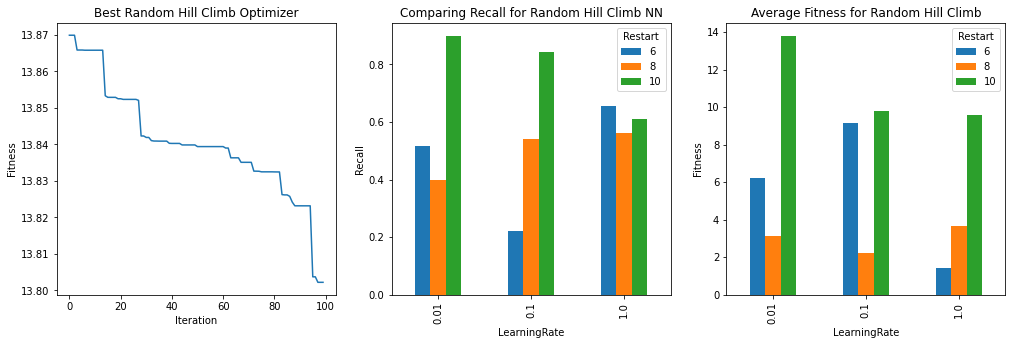

In [61]:
rh_scores_df = pd.DataFrame(rh_scores)

fig, ax = plt.subplots(1, 3, figsize=(17,5))
ax[0].plot(best_rh_model.fitness_curve[:,0])
ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')
ax[0].set_title('Best Random Hill Climb Optimizer')
rh_scores_df.groupby(['LearningRate', 'Restart']).mean().unstack()['Score'].plot.bar(ax=ax[1])
# ax[1].scatter(rh_scores_df['LearningRate'], rh_scores_df['Score'])
ax[1].set_ylabel('Recall')
# ax[1].set_xlabel('Learning Rate')
ax[1].set_title('Comparing Recall for Random Hill Climb NN');
rh_scores_df.groupby(['LearningRate', 'Restart']).mean().unstack()['Fitness'].plot.bar(ax=ax[2])
ax[2].set_title('Average Fitness for Random Hill Climb')
ax[2].set_ylabel('Fitness')

## Simulated Annealing

In [48]:
sa_scores     = []
best_sa_score = 0
best_sa_loss = 1000
best_sa_fitness = 0
best_sa_model = None
for lr in learning_rates:
    for i, schedule in enumerate(schedules):
        sa = mlrose_hiive.NeuralNetwork(
            hidden_nodes      = [25], 
            activation        = 'relu',
            algorithm         = 'simulated_annealing',
            schedule          = schedule, 
            is_classifier     = True,
            learning_rate     = lr,
            max_attempts      = 100,
            random_state      = 0,
            early_stopping    = True,
            curve             = True
        )
        start = time()
        sa.fit(X_train, y_train)
        sa_time = time() - start
        score = get_recall(sa, X_test, y_test)
        sa_fitness = sa.fitness_curve[-1,0]
        sa_scores.append({'LearningRate':lr, 'Schedule':scheduleNames[i], 'Score':score, 'Time':sa_time, 'Loss':sa.loss, 'Fitness':sa.fitness_curve[-1,0]})
        if sa_fitness > best_sa_fitness:
            best_sa_fitness = sa_fitness
            best_sa_model = sa
        print(f'best score: {best_sa_score} \
        Current Score: {score} \
        Learning Rate: {lr} \
        Schedule: {scheduleNames[i]}\
        Fitness: {sa_fitness}', 
              end='\r')    

Text(0, 0.5, 'Fitness')

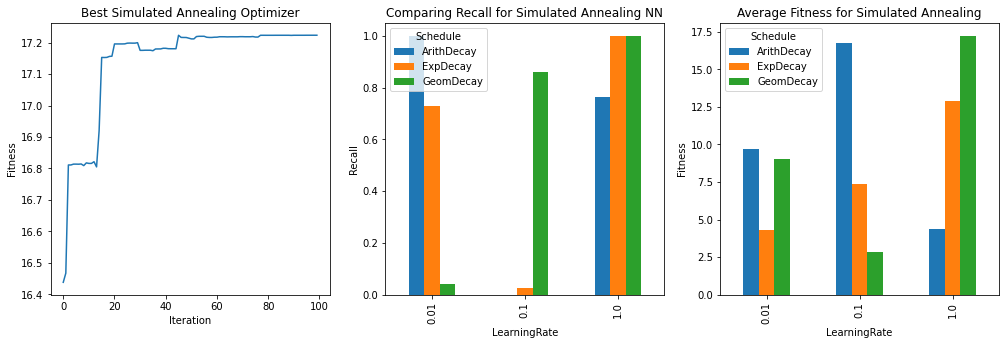

In [66]:
sa_scores_df = pd.DataFrame(sa_scores)
sa_scores_df['Schedule'] = sa_scores_df['Schedule'].astype(str)
fig, ax = plt.subplots(1, 3, figsize=(17,5))
ax[0].plot(best_sa_model.fitness_curve[:,0])
ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')
ax[0].set_title('Best Simulated Annealing Optimizer')
sa_scores_df.groupby(['LearningRate', 'Schedule']).mean().unstack()['Score'].plot.bar(ax=ax[1])
# ax[1].scatter(rh_scores_df['LearningRate'], rh_scores_df['Score'])
ax[1].set_ylabel('Recall')
# ax[1].set_xlabel('Learning Rate')
ax[1].set_title('Comparing Recall for Simulated Annealing NN');
sa_scores_df.groupby(['LearningRate', 'Schedule']).mean().unstack()['Fitness'].plot.bar(ax=ax[2])
ax[2].set_title('Average Fitness for Simulated Annealing')
ax[2].set_ylabel('Fitness')

## Genetic Algorithm

In [60]:
ga_scores     = []
best_ga_score = 0
best_ga_fitness = 0
best_ga_loss = 1000
best_ga_model = None
for lr in learning_rates:
    for pop in populations:
        ga = mlrose_hiive.NeuralNetwork(
            hidden_nodes      = [25], 
            activation        = 'relu',
            algorithm         = 'genetic_alg',
            pop_size          = pop, 
            is_classifier     = True,
            learning_rate     = lr,
            max_attempts      = 100,
            random_state      = 0,
            early_stopping    = True,
            curve             = True
        )
        start = time()
        ga.fit(X_train, y_train)
        ga_time = time() - start
        score = get_recall(ga, X_test, y_test)
        ga_fitness = ga.fitness_curve[-1,0]
        ga_scores.append({'LearningRate':lr, 'Population':pop, 'Score':score, 'Time':ga_time, 'Loss':ga.loss, 'Fitness':ga.fitness_curve[-1,0]})
        if ga_fitness >= best_ga_fitness:
            best_ga_fitness = ga_fitness
            best_ga_model = ga
        print(f'best score: {best_ga_fitness} \
        Current Score: {score} \
        Learning Rate: {lr} \
        Population: {pop}\
        Fitness: {ga_fitness}', 
              end='\r')

Text(0, 0.5, 'Fitness')

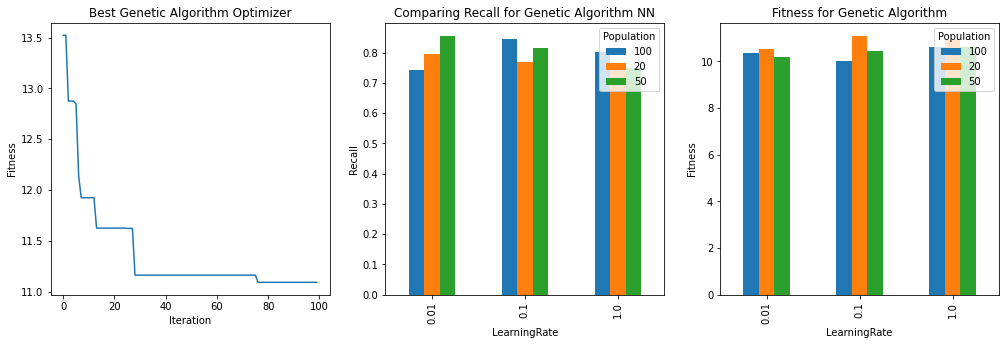

In [65]:
ga_scores_df = pd.DataFrame(ga_scores)
ga_scores_df['Population'] = ga_scores_df['Population'].astype(str)
fig, ax = plt.subplots(1, 3, figsize=(17,5))
ax[0].plot(best_ga_model.fitness_curve[:,0])
ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')
ax[0].set_title('Best Genetic Algorithm Optimizer')
ga_scores_df.groupby(['LearningRate', 'Population']).mean().unstack()['Score'].plot.bar(ax=ax[1])
# ax[1].scatter(rh_scores_df['LearningRate'], rh_scores_df['Score'])
ax[1].set_ylabel('Recall')
# ax[1].set_xlabel('Learning Rate')
ax[1].set_title('Comparing Recall for Genetic Algorithm NN');
ga_scores_df.groupby(['LearningRate', 'Population']).mean().unstack()['Fitness'].plot.bar(ax=ax[2])
ax[2].set_title('Fitness for Genetic Algorithm')
ax[2].set_ylabel('Fitness')

Text(0.5, 1.0, 'Fitness for Each Algorithm')

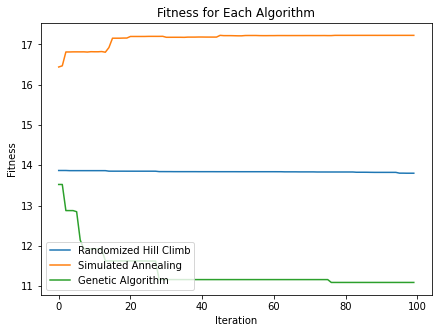

In [69]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(best_rh_model.fitness_curve[:,0], label='Randomized Hill Climb')
ax.plot(best_sa_model.fitness_curve[:,0], label='Simulated Annealing')
ax.plot(best_ga_model.fitness_curve[:,0], label='Genetic Algorithm')
ax.set_ylabel('Fitness')
ax.set_xlabel('Iteration')
ax.legend()
ax.set_title('Fitness for Each Algorithm')

<AxesSubplot:title={'center':'Recall Scores for Each Algorithm'}, xlabel='Algorithm', ylabel='Recall'>

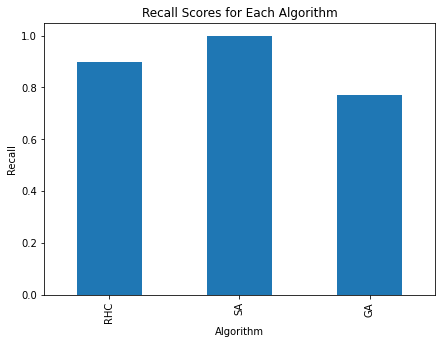

In [76]:
scores = pd.DataFrame({
    'RHC':[get_recall(best_rh_model, X_test, y_test)], 
    'SA':[get_recall(best_sa_model, X_test, y_test)], 
    'GA':[get_recall(best_ga_model, X_test, y_test)]
})
fig, ax = plt.subplots(figsize=(7,5))
scores.T.plot.bar(ax=ax, title='Recall Scores for Each Algorithm', xlabel='Algorithm', ylabel='Recall', legend=False)
# ax.plot(best_rh_model.fitness_curve[:,0], label='Randomized Hill Climb')
# ax.plot(best_sa_model.fitness_curve[:,0], label='Simulated Annealing')
# ax.plot(best_ga_model.fitness_curve[:,0], label='Genetic Algorithm')
# ax.set_ylabel('Fitness')
# ax.set_xlabel('Iteration')
# ax.legend()
# ax.set_title('Fitness for Each Algorithm')